<a href="https://colab.research.google.com/github/uthiralakshmi/CatsVsDogsClassifier/blob/master/ImageClassifierCNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-e251t_w8
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-e251t_w8
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=45c47bd12c3b8ac9938c700b67a724d4cb3fc640e9c0a890e421932e8d1eebe9
  Stored in directory: /tmp/pip-ephem-wheel-cache-aq0vbddb/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [2]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import CSVLogger
#from livelossplot import PlotLossesCallback
import efficientnet.keras as efn
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "cats_vs_dogs.h5"

# Data
#Train and validation
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

#test


test_dir = '/content/test'
num_test = len(os.listdir(test_dir))
print("Total test images:", num_test)


#path = "/home/greg/datasets/cats_and_dogs/"
#training_data_dir = path + "training" # 10 000 * 2
#validation_data_dir = path + "validation" # 2 500 * 2
#test_data_dir = path + "test" # 12 500

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000
Total test images: 2


In [4]:
# Hyperparams
IMAGE_SIZE = 150
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
epochs = 100
BATCH_SIZE = 128
TEST_SIZE = 10

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [5]:

model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH ,3)),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(512, 3, padding='same', activation='relu'),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True),
    MaxPooling2D(),
   
    Flatten(),
    Dense(1000, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
    Dense(250, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l=0.01)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7feb46851828>>

In [6]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [7]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [8]:
# Training
history = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    #callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE, append=False,separator=";")], 
    verbose=1)
#model.save_weights(MODEL_FILE)

Epoch 1/100
15/15 [==============================] - 184s 12s/step - loss: 22.5186 - accuracy: 0.5518 - val_loss: 21.0484 - val_accuracy: 0.4766
Epoch 2/100
15/15 [==============================] - 178s 12s/step - loss: 20.4073 - accuracy: 0.5903 - val_loss: 19.6403 - val_accuracy: 0.4931
Epoch 3/100
15/15 [==============================] - 177s 12s/step - loss: 18.9370 - accuracy: 0.6020 - val_loss: 18.1653 - val_accuracy: 0.4885
Epoch 4/100
15/15 [==============================] - 184s 12s/step - loss: 17.4042 - accuracy: 0.6365 - val_loss: 16.6579 - val_accuracy: 0.5069
Epoch 5/100
15/15 [==============================] - 177s 12s/step - loss: 15.8850 - accuracy: 0.6576 - val_loss: 15.1887 - val_accuracy: 0.4977
Epoch 6/100
15/15 [==============================] - 174s 12s/step - loss: 14.4450 - accuracy: 0.6765 - val_loss: 13.8181 - val_accuracy: 0.5183
Epoch 7/100
15/15 [==============================] - 180s 12s/step - loss: 13.1196 - accuracy: 0.6960 - val_loss: 12.6040 - val_ac

In [9]:
_, acc = model.evaluate_generator(validation_generator, steps=len(validation_generator.filenames) // BATCH_SIZE, verbose=0)
print('> %.3f' % (acc * 100.0))

> 79.911


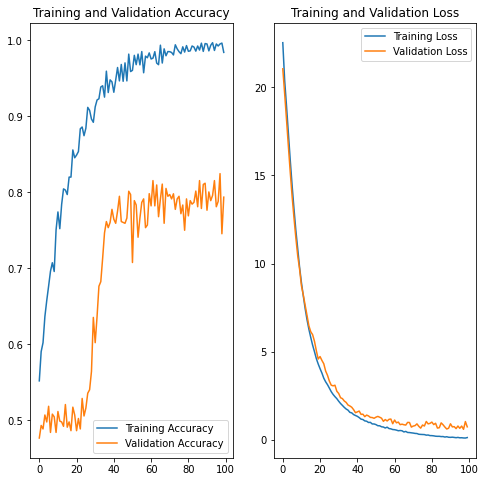

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

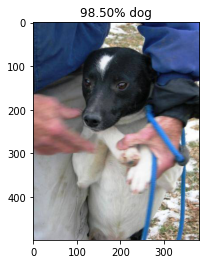

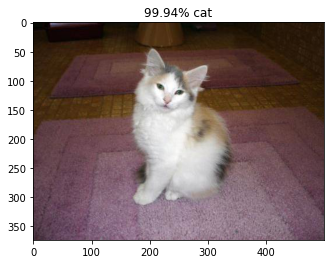

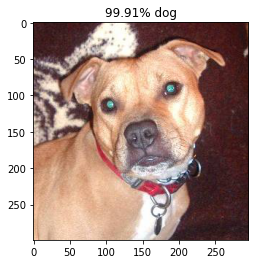

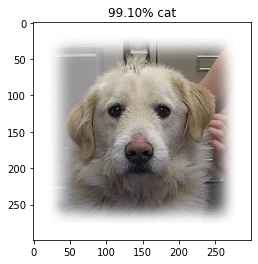

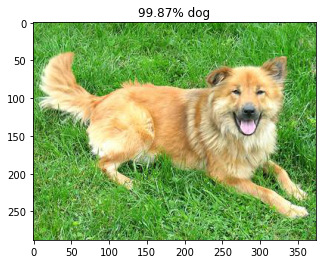

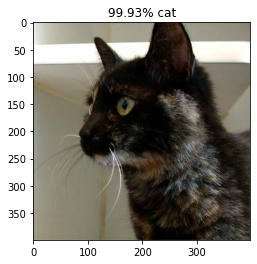

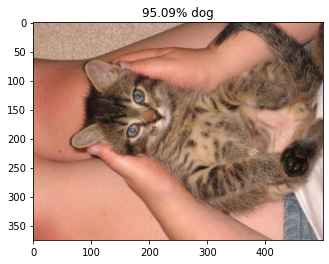

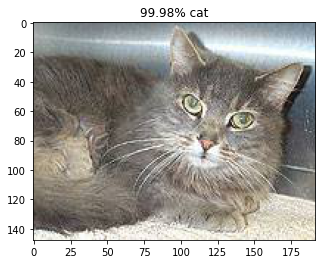

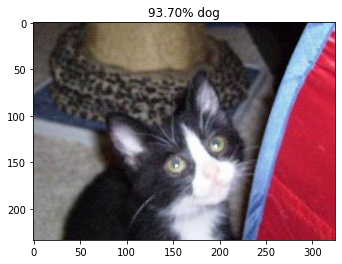

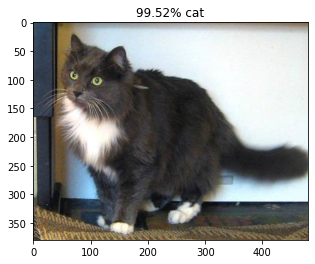

In [11]:
# Testing
probabilities = model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% dog")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
    plt.show()

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)      